Restarted GenAMM (Python 3.11.4)

In [1]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

In [2]:
#----------------------------------- Compute the price ranges
with open('../data/df_mint_clean.pickle', 'rb') as f:
    df_mint_clean = pickle.load(f)

up_bound = np.log(10**9) / np.log(1.0001)
low_bound = np.log(10**9/6) / np.log(1.0001)
length_list_log_clean = list()
for mint_iloc in tqdm(range(len(df_mint_clean))): #Iterate over the mint events
    tu, tl = df_mint_clean.iloc[mint_iloc].tick_upper, df_mint_clean.iloc[mint_iloc].tick_lower
    if (tu <= up_bound) and (tl >= low_bound):
        length_list_log_clean.append(tu - tl)
length_list_log_clean = np.array(length_list_log_clean)

#----------------------------------- Fit the q-Power Law
x_train = length_list_log_clean.copy()

  0%|          | 0/21991 [00:00<?, ?it/s]

In [3]:
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto

In [4]:
from scipy.integrate import quad

(1.9586916807008397, -1419.4580389275507, 1439.4580389275504)


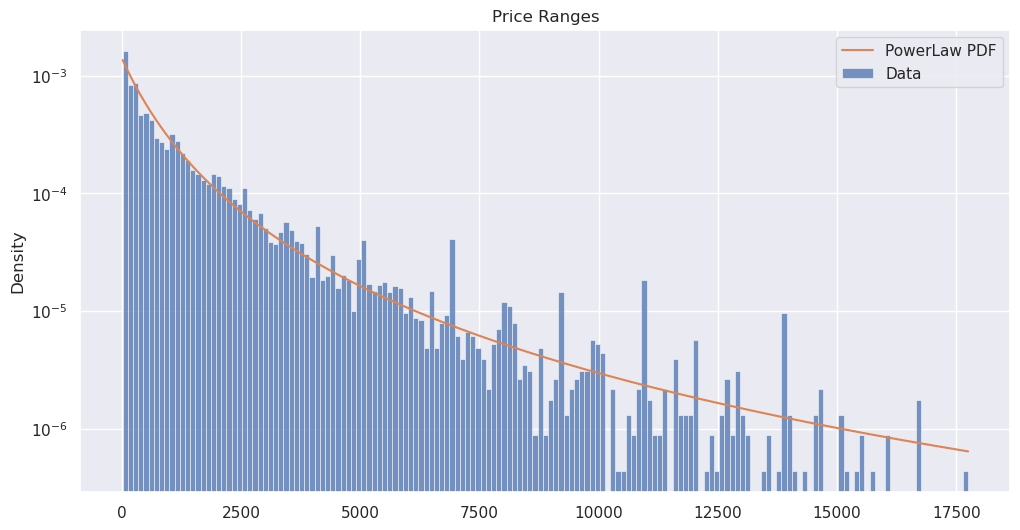

In [5]:

my_p_pars = pareto.fit(x_train)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
num_bins = len(ax.patches) # Number of bins
temp = ax.patches
hist_values = np.histogram(x_train, bins=num_bins, density=True)[0] #Obtain the histogram values
hist_values /= np.sum(hist_values) # Normalize the values
pdf = pareto.pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='PowerLaw PDF')

plt.title('Price Ranges')
ax.legend()
plt.show()

{'alpha': 0.361434287388345, 'loc': 2.404614032365349, 'scale': 17.595380256599405, 'neg_ll': 178825.130256152}


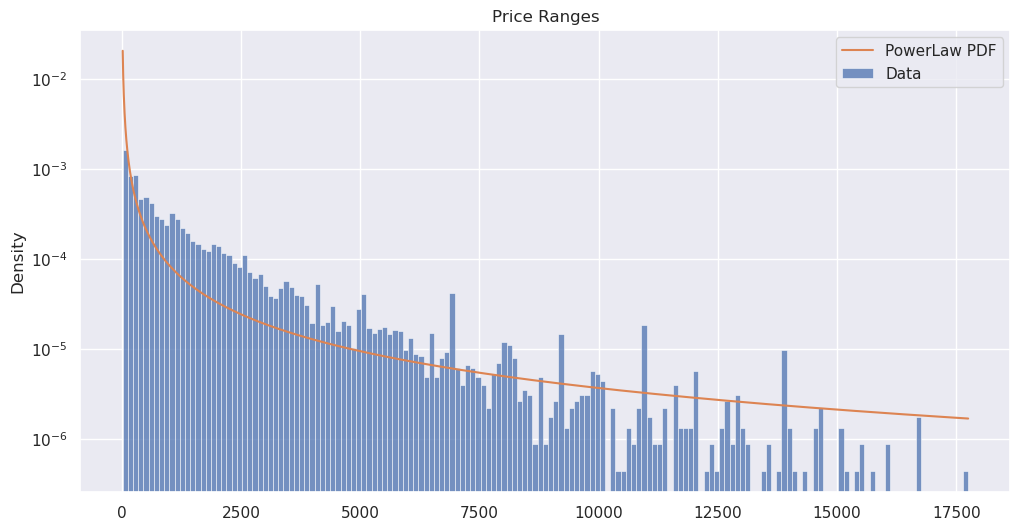

In [6]:

my_pl_pars = qPowerLaw.PowerLaw_fit(x_train)
print(my_pl_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
num_bins = len(ax.patches) # Number of bins
temp = ax.patches
hist_values = np.histogram(x_train, bins=num_bins, density=True)[0] #Obtain the histogram values
hist_values /= np.sum(hist_values) # Normalize the values
pdf = qPowerLaw.PowerLaw_pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *list(my_pl_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='PowerLaw PDF')

plt.title('Price Ranges')
ax.legend()
plt.show()

{'alpha': 0.1251671545366937, 'l': 0.0013829647826495864, 'loc': 3.7296268406519943, 'scale': 16.27037162818995, 'neg_ll': 172928.72409333917}


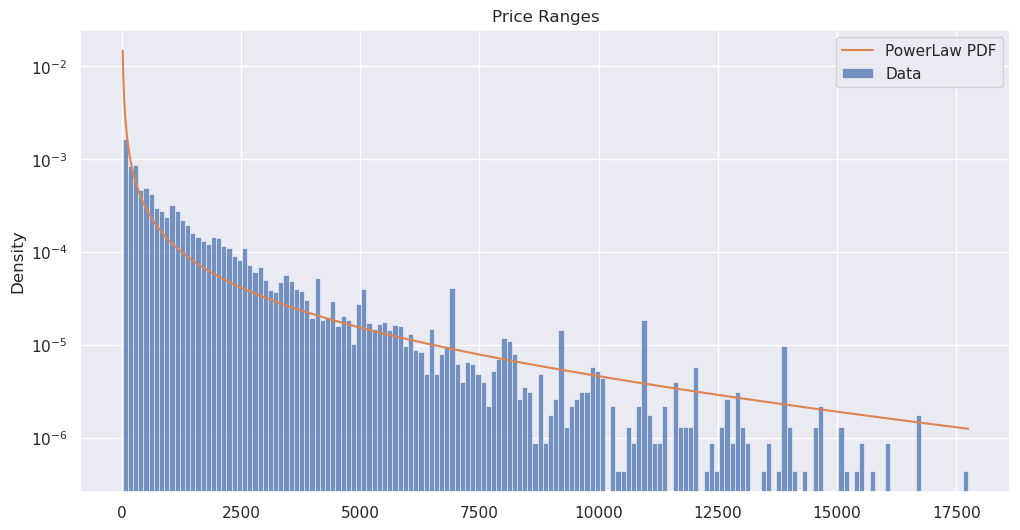

In [8]:

my_expl_pars = qPowerLaw.PowerLaw_exp_fit(x_train)
print(my_expl_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
num_bins = len(ax.patches) # Number of bins
temp = ax.patches
hist_values = np.histogram(x_train, bins=num_bins, density=True)[0] #Obtain the histogram values
hist_values /= np.sum(hist_values) # Normalize the values
pdf = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *list(my_expl_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='PowerLaw PDF')

plt.title('Price Ranges')
ax.legend()
plt.show()

{'q': 1.3813136332486247, 'alpha': 5.383222782777892, 'l': 0.00021910830710041487, 'loc': -5599.800571681629, 'scale': 5619.800570453758, 'neg_ll': 170559.245742339}


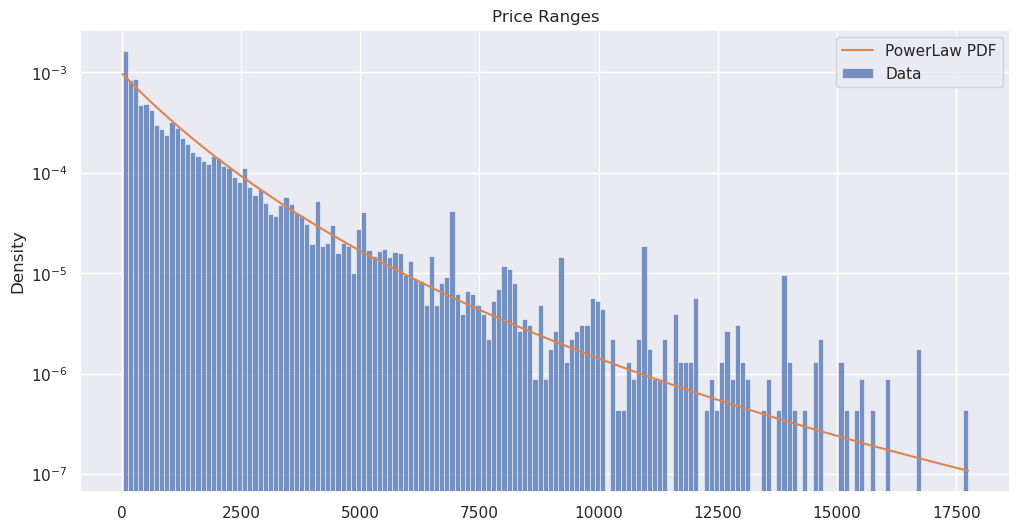

In [9]:

my_qexpl_pars = qPowerLaw.fit(x_train)
print(my_qexpl_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
num_bins = len(ax.patches) # Number of bins
temp = ax.patches
hist_values = np.histogram(x_train, bins=num_bins, density=True)[0] #Obtain the histogram values
hist_values /= np.sum(hist_values) # Normalize the values
pdf = qPowerLaw.pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *list(my_qexpl_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='PowerLaw PDF')

plt.title('Price Ranges')
ax.legend()
plt.show()

(20.0, 1334.3939899833056)


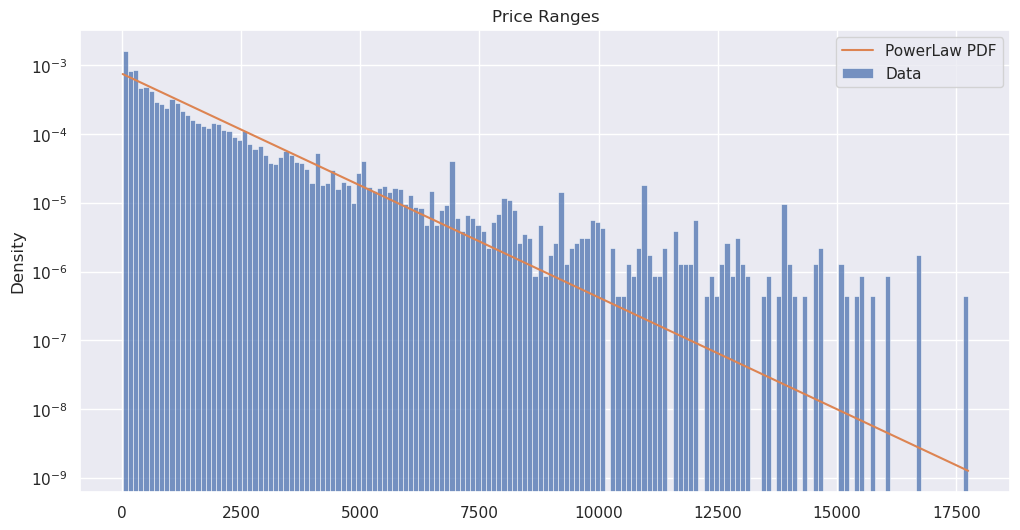

In [13]:

from scipy.stats import expon

my_ex_pars = expon.fit(x_train)
print(my_ex_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
num_bins = len(ax.patches) # Number of bins
temp = ax.patches
hist_values = np.histogram(x_train, bins=num_bins, density=True)[0] #Obtain the histogram values
hist_values /= np.sum(hist_values) # Normalize the values
pdf = expon.pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *my_ex_pars)
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='PowerLaw PDF')

plt.title('Price Ranges')
ax.legend()
plt.show()

(1.9586916807008397, -1419.4580389275507, 1439.4580389275504)


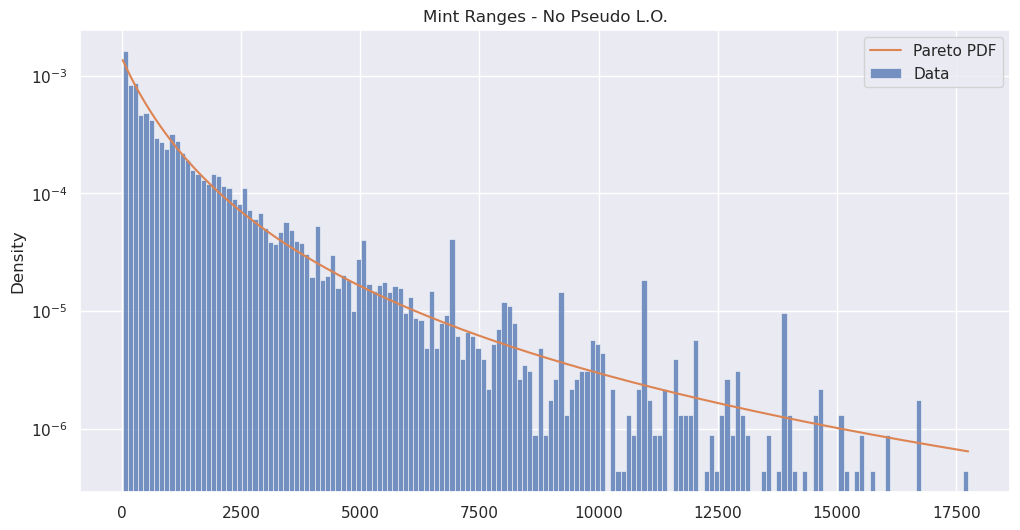

In [18]:

my_p_pars = pareto.fit(x_train)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_train, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
pdf = pareto.pdf(np.linspace(np.min(x_train), np.max(x_train), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(x_train), np.max(x_train), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Pareto PDF')

plt.title('Mint Ranges - No Pseudo L.O.')
ax.legend()
plt.show()

In [19]:
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))

x_train = length_list_log_clean.copy()
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto']):
    try:
        pars = dist.fit(x_train)
        print(f"{name} - Parameters: {pars}")
        curr_ll = general_ll(x_train, dist.pdf, pars)
        print(f"{name} - Log-Likelihood: {curr_ll}")
        if curr_ll > max_ll:
            max_ll = curr_ll
            best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (19.999999999998437, 594.1779133134819)
Half-Cauchy - Log-Likelihood: -170995.34870827143

Fatigue Life - Parameters: (1.6910860358866082, -19.52079023582069, 552.0577368038098)
Fatigue Life - Log-Likelihood: -170395.39365875348

Generalized Pareto - Parameters: (0.5104206938572415, 19.9999997276781, 734.9660372461099)
Generalized Pareto - Log-Likelihood: -170032.23189509267

Kappa 3 - Parameters: (1.2160153133621578, 19.99999999975129, 622.0555726536452)
Kappa 3 - Log-Likelihood: -170386.83803795784

Pareto - Parameters: (1.9586916807008397, -1419.4580389275507, 1439.4580389275504)
Pareto - Log-Likelihood: -170032.23183589487

The best distribution is: Pareto, with a Log-Likelihood of -170032.23183589487


In [20]:
# Verify the intuition via bootstrap test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

In [21]:
boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = pareto
top_pars = top_dist.fit(x_train)
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife']):
    temp_par = dist.fit(x_train)
    test_res = boot_test(
        x_train, lambda x: top_dist.pdf(x, *top_pars),
        lambda x: dist.pdf(x, *temp_par), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -54.416996147490686, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -0.006529016551924202, 'p_value': 0.502}
Kappa 3 - test result: {'statistic': -31.983485921287027, 'p_value': 0.0}
FatigueLife - test result: {'statistic': -11.742903628089687, 'p_value': 0.0}


In [23]:
temp_par = qPowerLaw.fit(x_train)
test_res = boot_test(
    x_train, lambda x: top_dist.pdf(x, *top_pars),
    lambda x: qPowerLaw.pdf(x, *list(temp_par.values())[:-1]), random_seed)
print(f"PowerLaw-qExp - test result: {test_res}")

PowerLaw-qExp - test result: {'statistic': -14.798050475046526, 'p_value': 0.0}
